In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits

import os

from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [3]:
import torch
import flowtorch.bijectors as bij
import flowtorch.distributions as dist

In [4]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz_estimates
from scipy import stats

In [14]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal


In [6]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [7]:
photoz_archive = archive(path = parent_dir, Qz_cut=0.5)
f, ferr, specz, specqz = photoz_archive.get_training_data()

In [8]:
dset = TensorDataset(torch.Tensor(f), torch.Tensor(specz))
loader = DataLoader(dset, batch_size=64, shuffle=True)

In [9]:
# Define the base distribution (standard Gaussian)
base_distribution = torch.distributions.Normal(0, 1)

In [15]:
class SimpleAffine(nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.a = nn.Parameter(torch.zeros(self.dim))  # log_scale
        self.b = nn.Parameter(torch.zeros(self.dim))  # shift

    def forward(self, x):
        y = torch.exp(self.a) * x + self.b

        det_jac = torch.exp(self.a.sum())
        log_det_jac = torch.ones(y.shape[0]) * torch.log(det_jac)

        return y, log_det_jac

    def inverse(self, y):
        x = (y - self.b) / torch.exp(self.a)

        det_jac = 1 / torch.exp(self.a.sum())
        inv_log_det_jac = torch.ones(y.shape[0]) * torch.log(det_jac)

        return x, inv_log_det_jac


In [16]:
class StackSimpleAffine(nn.Module):
    def __init__(self, transforms, dim=2):
        super().__init__()
        self.dim = dim
        self.transforms = nn.ModuleList(transforms)
        self.distribution = MultivariateNormal(torch.zeros(self.dim), torch.eye(self.dim))

    def log_probability(self, x):
        log_prob = torch.zeros(x.shape[0])
        for transform in reversed(self.transforms):
            x, inv_log_det_jac = transform.inverse(x)
            log_prob += inv_log_det_jac

        log_prob += self.distribution.log_prob(x)

        return log_prob

    def rsample(self, num_samples):
        x = self.distribution.sample((num_samples,))
        log_prob = self.distribution.log_prob(x)

        for transform in self.transforms:
            x, log_det_jac = transform.forward(x)
            log_prob += log_det_jac

        return x, log_prob

In [139]:
class RealNVPNode(nn.Module):
    def __init__(self, mask, hidden_size):
        super(RealNVPNode, self).__init__()
        self.dim = len(mask)
        self.mask = nn.Parameter(mask, requires_grad=False)

        self.s_func = nn.Sequential(nn.Linear(in_features=self.dim, out_features=hidden_size), nn.LeakyReLU(),
                                    nn.Linear(in_features=hidden_size, out_features=hidden_size), nn.LeakyReLU(),
                                    nn.Linear(in_features=hidden_size, out_features=self.dim))

        self.scale = nn.Parameter(torch.Tensor(self.dim))

        self.t_func = nn.Sequential(nn.Linear(in_features=self.dim, out_features=hidden_size), nn.LeakyReLU(),
                                    nn.Linear(in_features=hidden_size, out_features=hidden_size), nn.LeakyReLU(),
                                    nn.Linear(in_features=hidden_size, out_features=self.dim))

    def forward(self, x):
        x_mask = x*self.mask
        s = self.s_func(x_mask) * self.scale
        t = self.t_func(x_mask)

        y = x_mask + (1 - self.mask) * (x*torch.exp(s) + t)

        # Sum for -1, since for every batch, and 1-mask, since the log_det_jac is 1 for y1:d = x1:d.
        log_det_jac = ((1 - self.mask) * s).sum(-1)
        return y, log_det_jac

    def inverse(self, y):
        print('1',y[12],self.mask)
        y_mask = y * self.mask
        print('2',y_mask[12])
        s = self.s_func(y_mask) * self.scale
        print('3',s[12])
        print('3a',self.s_func(y_mask)[12])
        print('3b',self.scale)
        t = self.t_func(y_mask)
        print('4',t[12])

        x = y_mask + (1-self.mask)*(y - t)*torch.exp(-s)
        print('5',x[12])

        inv_log_det_jac = ((1 - self.mask) * -s).sum(-1)

        return x, inv_log_det_jac


In [ ]:
    def inverse(self, y):
        print('1',y[12],self.mask)
        y_mask = y * self.mask
        print('2',y_mask[12])
        s = self.s_func(y_mask) * self.scale
        print('3',s[12])
        print('3a',self.s_func(y_mask)[12])
        print('3b',self.scale)
        t = self.t_func(y_mask)
        print('4',t[12])

        x = y_mask + (1-self.mask)*(y - t)*torch.exp(-s)
        print('5',x[12])

        inv_log_det_jac = ((1 - self.mask) * -s).sum(-1)

        return x, inv_log_det_jac

In [140]:
class RealNVP(nn.Module):
    def __init__(self, masks, hidden_size):
        super(RealNVP, self).__init__()

        self.dim = len(masks[0])
        self.hidden_size = hidden_size

        self.masks = nn.ParameterList([nn.Parameter(torch.Tensor(mask), requires_grad=False) for mask in masks])
        self.layers = nn.ModuleList([RealNVPNode(mask, self.hidden_size) for mask in self.masks])

        self.distribution = MultivariateNormal(torch.zeros(self.dim), torch.eye(self.dim))

    def log_probability(self, x):
        log_prob = torch.zeros(x.shape[0])
        for layer in reversed(self.layers):
            x, inv_log_det_jac = layer.inverse(x)
            log_prob += inv_log_det_jac
        log_prob += self.distribution.log_prob(x)

        return log_prob

    def rsample(self, num_samples):
        x = self.distribution.sample((num_samples,))
        log_prob = self.distribution.log_prob(x)

        for layer in self.layers:
            x, log_det_jac = layer.forward(x)
            log_prob += log_det_jac

        return x, log_prob

    def sample_each_step(self, num_samples):
        samples = []

        x = self.distribution.sample((num_samples,))
        samples.append(x.detach().numpy())

        for layer in self.layers:
            x, _ = layer.forward(x)
            samples.append(x.detach().numpy())

        return samples

In [153]:
torch.manual_seed(2)
np.random.seed(0)
ninput=6
nlayers= 4

masks = torch.randint(0, 2, size=(nlayers,ninput), dtype=torch.float32)
hidden_size = 32

NVP_model = RealNVP(masks, hidden_size)

In [154]:
def train(model, data, epochs = 100, batch_size = 64):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters())
    
    losses = []
    with tqdm.tqdm(range(epochs), unit=' Epoch') as tepoch:
        epoch_loss = 0
        for epoch in tepoch:
            for training_sample, training_label in train_loader:
                log_prob = model.log_probability(training_sample)
                loss = - log_prob.mean(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss
            epoch_loss /= len(train_loader)
            losses.append(np.copy(epoch_loss.detach().numpy()))
            tepoch.set_postfix(loss=epoch_loss.detach().numpy())

    return model, losses

In [155]:
model, loss = train(NVP_model, dset, epochs = 1000)

  0%|          | 0/1000 [00:00<?, ? Epoch/s]


1 tensor([0.5588, 0.5051, 0.8231, 0.8420, 0.8778, 0.7652]) Parameter containing:
tensor([0., 0., 0., 0., 1., 1.])
2 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.8778, 0.7652])
3 tensor([ 1.7198e+00, -1.7909e-42,  1.1632e-19, -4.0638e-43, -7.0065e-45,
        -1.6816e-44], grad_fn=<SelectBackward0>)
3a tensor([-0.0042, -0.1158,  0.0854, -0.0132, -0.0431, -0.1054],
       grad_fn=<SelectBackward0>)
3b Parameter containing:
tensor([-4.0794e+02,  1.5475e-41,  1.3620e-18,  3.0681e-41,  1.6395e-43,
         1.5975e-43], requires_grad=True)
4 tensor([ 0.0516,  0.2844, -0.0888,  0.0503, -0.1146,  0.2456],
       grad_fn=<SelectBackward0>)
5 tensor([0.0908, 0.2207, 0.9120, 0.7917, 0.8778, 0.7652],
       grad_fn=<SelectBackward0>)
1 tensor([0.0908, 0.2207, 0.9120, 0.7917, 0.8778, 0.7652],
       grad_fn=<SelectBackward0>) Parameter containing:
tensor([1., 1., 1., 1., 1., 1.])
2 tensor([0.0908, 0.2207, 0.9120, 0.7917, 0.8778, 0.7652],
       grad_fn=<SelectBackward0>)
3 tensor([ 2.8026e-45,  5.6052

ValueError: Expected value argument (Tensor of shape (64, 6)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([6]), covariance_matrix: torch.Size([6, 6])), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]], grad_fn=<AddBackward0>)

In [89]:
torch.manual_seed(42)

# Create the dataset
n_samples = 1000
dataset = create_dataset(n_samples)



# Training the model


# Generate samples from the model
n_generated_samples = 1000
with torch.no_grad():
    z_samples = base_distribution.sample((n_generated_samples,))
    generated_samples, _ = flow_model(z_samples)

# Plot the generated samples and the original dataset
import matplotlib.pyplot as plt

plt.scatter(dataset[:, 0], dataset[:, 1], label="Original Data", alpha=0.5)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label="Generated Data", alpha=0.5)
plt.legend()
plt.show()


In [88]:
num_iter = 5000
for i in range(num_iter):
    for ff,zs in loader:
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=ff, context=zs.reshape(-1, 1)).mean()
        loss.backward()
        optimizer.step()
        
    assert False
    


RuntimeError: shape '[64, 6]' is invalid for input of size 128

In [ ]:
    if (i + 1) % 500 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5,100)
        yline = torch.linspace(-.75, 1.25,100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()


In [38]:
base_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 
  1
)
target_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2)+5, torch.ones(2)*0.5),
  1
)

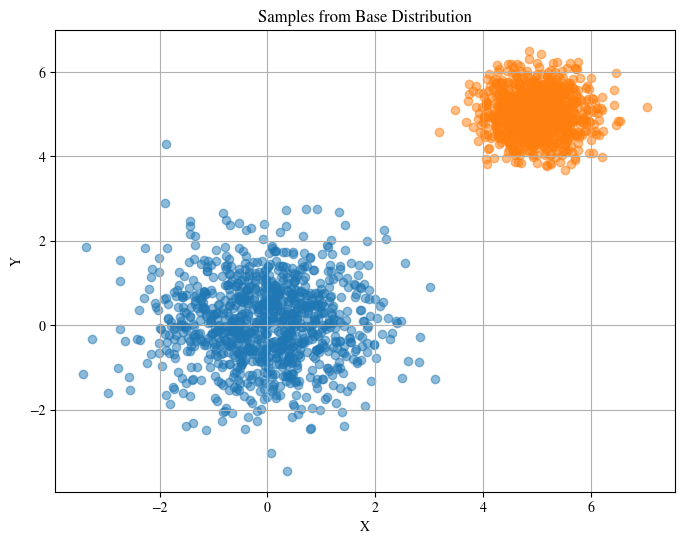

In [39]:
num_samples = 1000
samples_base = base_dist.sample((num_samples,))
samples_target = target_dist.sample((num_samples,))

# Extract x and y coordinates for plotting
x_values_base = samples_base[:, 0].numpy()
y_values_base = samples_base[:, 1].numpy()

x_values_target = samples_target[:, 0].numpy()
y_values_target = samples_target[:, 1].numpy()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values_base, y_values_base, alpha=0.5)
plt.scatter(x_values_target, y_values_target, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Base Distribution')
plt.grid(True)
plt.show()

##### Normalizing flow with a single transformation

In [8]:
bijectors = bij.AffineAutoregressive()

In [9]:
flow = dist.Flow(base_dist, bijectors)

In [10]:
# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=5e-3)
for idx in range(3001):
    opt.zero_grad()

    # Minimize KL(p || q)
    y = target_dist.sample((1000,))
    loss = -flow.log_prob(y).mean()

    if idx % 500 == 0:
        print('epoch', idx, 'loss', loss)

    loss.backward()
    opt.step()

epoch 0 loss tensor(23.8129, grad_fn=<NegBackward0>)
epoch 500 loss tensor(3.6865, grad_fn=<NegBackward0>)
epoch 1000 loss tensor(3.2616, grad_fn=<NegBackward0>)
epoch 1500 loss tensor(3.0639, grad_fn=<NegBackward0>)
epoch 2000 loss tensor(2.5082, grad_fn=<NegBackward0>)
epoch 2500 loss tensor(1.6517, grad_fn=<NegBackward0>)
epoch 3000 loss tensor(1.4682, grad_fn=<NegBackward0>)


In [25]:
dist_y = dist.Flow(base_dist, bijectors)

In [28]:
num_samples = 1000
samples_pred = dist_y.sample((num_samples,))



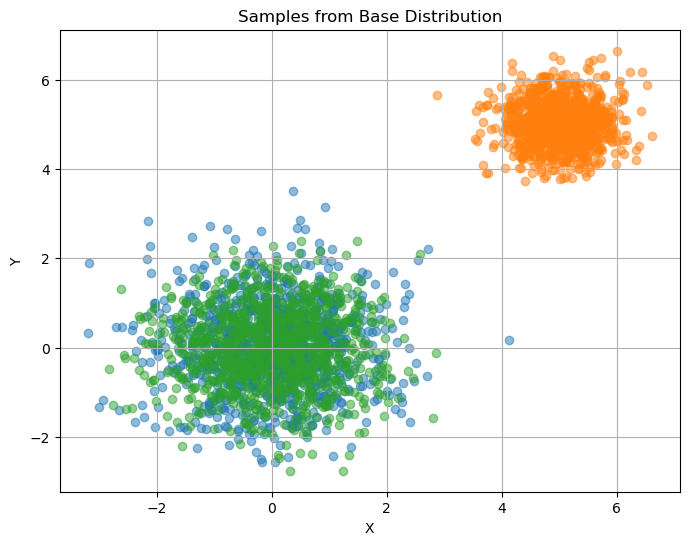

In [29]:
num_samples = 1000
samples_base = base_dist.sample((num_samples,))
samples_target = target_dist.sample((num_samples,))

# Extract x and y coordinates for plotting
x_values_base = samples_base[:, 0].numpy()
y_values_base = samples_base[:, 1].numpy()

x_values_target = samples_target[:, 0].numpy()
y_values_target = samples_target[:, 1].numpy()

# Extract x and y coordinates for plotting
x_values_pred = samples_pred[:, 0].numpy()
y_values_pred = samples_pred[:, 1].numpy()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values_base, y_values_base, alpha=0.5)
plt.scatter(x_values_target, y_values_target, alpha=0.5)
plt.scatter(x_values_pred, y_values_pred, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Base Distribution')
plt.grid(True)
plt.show()

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [62]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [63]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [64]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.715
iter 500: loss = 0.835
iter 1000: loss = 0.493
iter 1500: loss = 0.592
iter 2000: loss = 0.467
iter 2500: loss = 0.298
iter 3000: loss = 0.396
iter 3500: loss = 0.368
iter 4000: loss = 0.306
iter 4500: loss = 0.486
iter 5000: loss = 0.458


In [66]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()

In [68]:
z

array([[-1.8747659e-01,  3.8629249e-01],
       [-4.5098123e-01,  1.1165810e+00],
       [ 2.7200544e-01,  4.9045309e-01],
       ...,
       [-1.9135862e-03, -1.3994721e+00],
       [ 1.8429850e+00,  4.9667689e-01],
       [ 2.3594198e+00, -1.4860994e-01]], dtype=float32)

Text(0.5, 1.0, '$X = g(z)$')

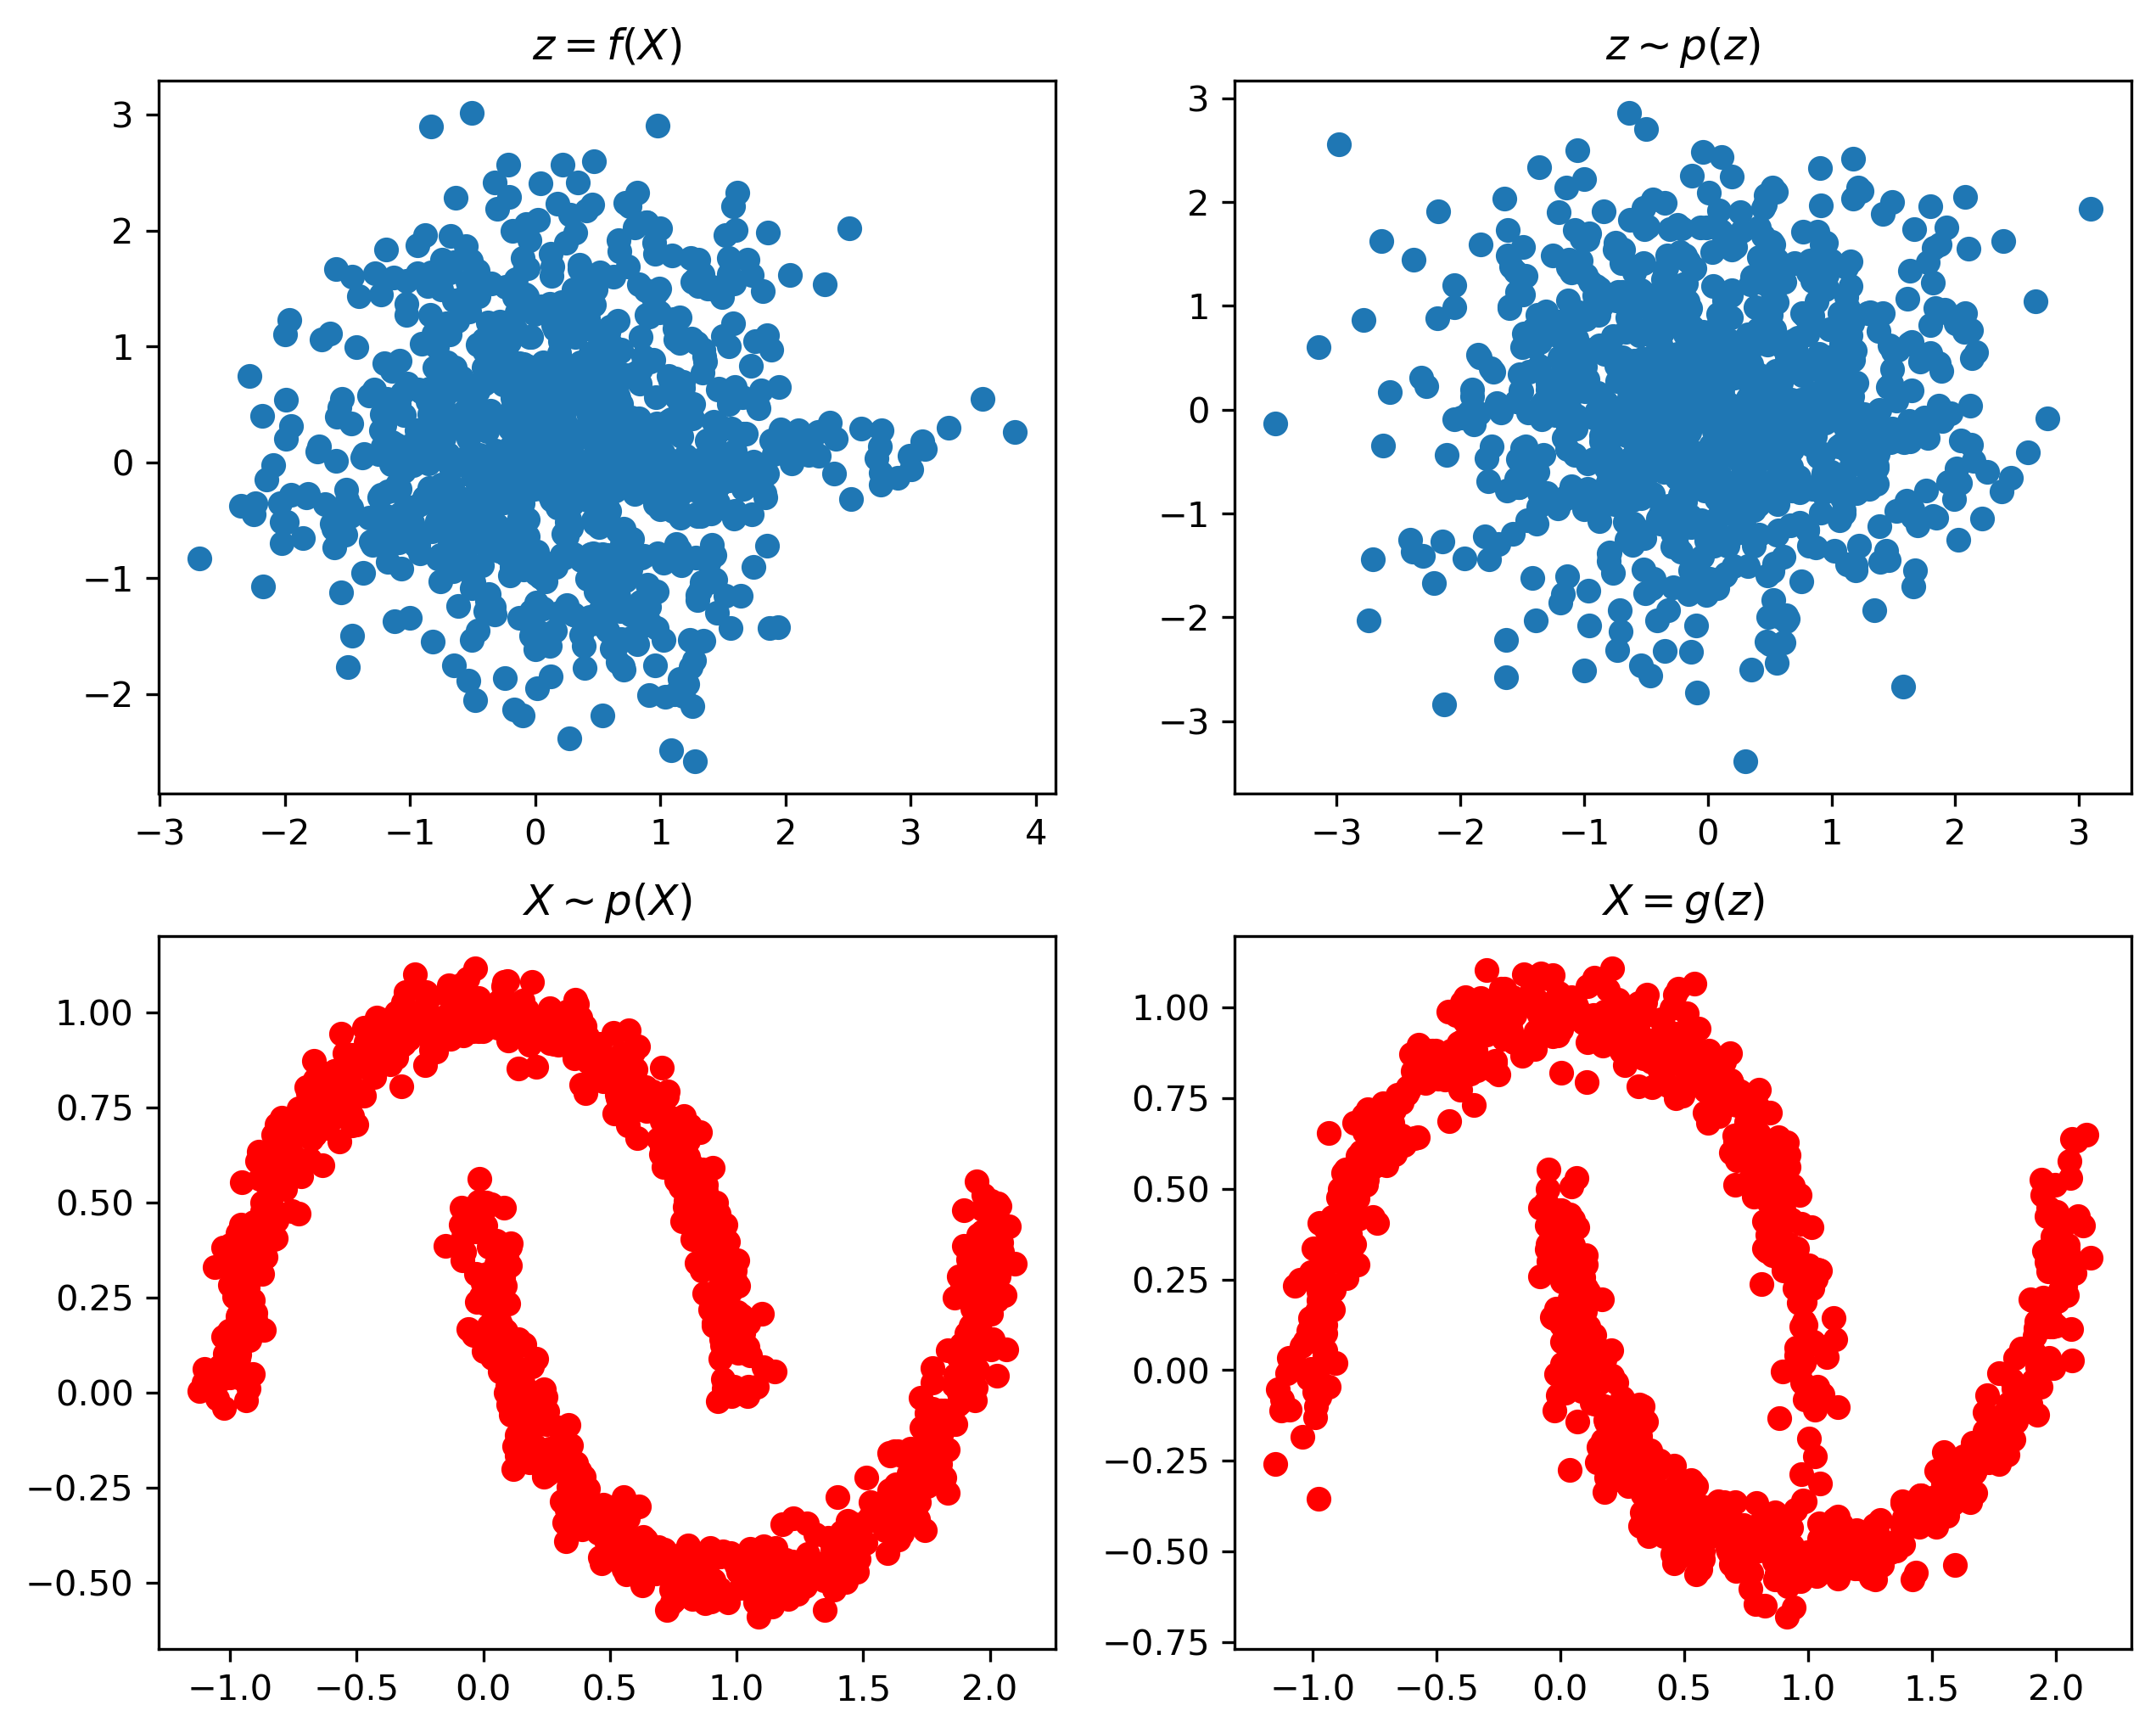

In [65]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## WITH NFLOWS

In [92]:
nflow.bijectors

NameError: name 'nflow' is not defined

In [59]:
num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[6], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=4, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [60]:
num_iter = 50
for i in range(num_iter):
    for ff, zs in loader:
        print(ff.shape, zs.shape)
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=ff, context=zs.reshape(-1, 1)).mean()
        loss.backward()
        optimizer.step()
    



torch.Size([64, 6]) torch.Size([64])


RuntimeError: shape '[64, 6]' is invalid for input of size 128

In [ ]:
    if (i + 1) % 500 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5,100)
        yline = torch.linspace(-.75, 1.25,100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()